In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


def character_table(csv_file, class_start_date):
    df_uploaded = pd.read_csv(csv_file)
    class_start_date =  datetime.strptime(class_start_date , '%Y-%m-%d').date()
    user = df_uploaded['get_user_ID'].unique()
    
    Table = {}     
    Learners = {}
    
    for i in user:
        Table[i] = df_uploaded.loc[df_uploaded['get_user_ID'] == i]
        Table[i]['get_user_ID'] = Table[i]['get_user_ID'].astype(str)
        Table[i] = Table[i].replace('不足1s', '00:00:01')
        Table[i]['time_spent'] = pd.to_timedelta(Table[i].time_spent)
        Table[i]['visit_time'] = pd.to_datetime(Table[i].visit_time, format='%Y.%m.%d %H:%M')
        Table[i]['visit_date'] = Table[i]['visit_time'].dt.date
        Table[i] = Table[i].sort_values('visit_time')
        Table[i]['time_spent'] = Table[i]['time_spent'].dt.total_seconds()
        Table[i] = Table[i].groupby(['visit_date']).agg(time_sum = 
                                                         ('time_spent', 'sum'),
                                                         visits_count = 
                                                         ('visit_time', 'count')).reset_index()
        Table[i]['day_difference'] = Table[i].diff(periods=1, axis=0)['visit_date'].fillna(pd.Timedelta(days=0))  
        Table[i]['day_difference'] = Table[i]['day_difference'].apply(lambda x: x.days)
        Table[i]['time_spent_pv'] = Table[i]['time_sum']/Table[i]['visits_count']        
        Learners["LEARNER{0}".format(i)] = []
     
        sum_Q1 = Table[i]['time_sum'].quantile(0.25)
        sum_Q3 = Table[i]['time_sum'].quantile(0.75)
        sum_IQR = sum_Q3 - sum_Q1
        
        before_class = Table[i][(Table[i]['visit_date'] < class_start_date)]['time_sum']
        after_class = Table[i][(Table[i]['visit_date'] >= class_start_date)]['time_sum']
        if before_class.sum(axis=0) > 0:
            meta = 1
            moti = before_class.median()
        else: 
            meta = 0
            moti = 0
                     
        half = round(Table[i].shape[0]/2)
        first_half = Table[i].loc[:half, 'time_sum'] 
        second_half = Table[i].loc[half:, 'time_sum']  
        
        #Six Character Features
        Grit = Table[i]['time_sum'].median() / sum_IQR
        Self_control = Table[i]['time_spent_pv'].median()
        Meta_cog_Self_reg = (meta + (Table[i]['day_difference'].isin(Table[i]['day_difference'].mode()).count()/(Table[i]['day_difference'].nunique()))) / sum_IQR
        Motivation = moti + after_class.median()
        Engagement = Table[i]['time_sum'].median()
        Self_perception = -math.log(1 + abs(first_half.median() - second_half.median()))
                
        Learners["LEARNER{0}".format(i)].extend([str(i), Grit, Self_control, Meta_cog_Self_reg, Motivation, Engagement, Self_perception])    
        
    Learners_col = ['user_ID', 'Grit', 'Self_control', 'Meta_cog_Self_reg', 'Motivation', 'Engagement', 'Self_perception']
    df_Learners = pd.DataFrame(columns = Learners_col)
    for i in user:
        a_series = pd.Series(Learners['LEARNER' + str(i)], index = df_Learners.columns)
        df_Learners = df_Learners.append(a_series, ignore_index=True)
    df_Learners.set_index('user_ID', inplace=True)
    df_Learners = df_Learners.astype(np.float64)
        
    print(df_Learners.isnull().sum().sum())
    print(df_Learners.isin([np.inf, -np.inf]).sum().sum())        
    scaler = MinMaxScaler()    
    df_Learners_scaled = df_Learners[:]
    df_Learners_scaled = scaler.fit_transform(df_Learners_scaled)    
    table = pd.DataFrame(df_Learners_scaled, index = df_Learners.index, 
                                          columns = df_Learners.columns)

    return table

In [2]:
def character_PCA(table, PC_n=3):
    #PC_n=3 is default which is considered fixed.
    pca = PCA(n_components=PC_n, svd_solver = "full")
    pca_result = pca.fit_transform(table)
    df_Learners_scaled_PCA = table[:]
    for i in range(PC_n):
        df_Learners_scaled_PCA['PC' + str(i + 1)] = pca_result[:, i]

    (fig, ax) = plt.subplots(figsize=(11, 11))  #create a fig with 1 ax
    for i in range(0, len(table.columns)):    
        ax.arrow(0,
                 0,    
                 pca.components_[0, i],    
                 pca.components_[1, i],    
                 head_width=0.01,
                 head_length=0.01,
                color = 'slategray')
        plt.text(pca.components_[0, i] + 0.005,
                 pca.components_[1, i] + 0.005,
                 table.columns[i], 
                color = 'slategray')    
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(1 * np.cos(an), 1* np.sin(an), color = 'slategray') 
    plt.axis('equal')
    ax.set_title('Variable factor map')

    ax.spines['left'].set_position('zero')  
    ax.spines['bottom'].set_position('zero')  

    plt.axvline(0) 
    plt.axhline(0) 
    plt.show()

    (fig1, ax) = plt.subplots(figsize=(7, 5))  #create a fig with 1 ax  
    check_eigenValues_pca = pca.explained_variance_ratio_
    plt.bar(range(1, len(check_eigenValues_pca)+1), check_eigenValues_pca, color = 'slategray')
    plt.ylabel('Explained variance')
    plt.xlabel('Components')
    plt.plot(range(1,len(check_eigenValues_pca)+1),
             np.cumsum(check_eigenValues_pca),
             c='black',
             label="Cumulative Explained Variance")
    plt.legend(loc='center right')
    plt.close()
    return fig1

In [3]:
def character_kmeans(table, cluster_n=10, PC_n=2): 
    #PC_n=2 & cluster_n=10 are default which is considered fixed.
    pca = PCA(n_components=PC_n, svd_solver = "full")
    pca_result = pca.fit_transform(table)
    df_Learners_scaled_PCA = table[:]
    for i in range(PC_n):
        df_Learners_scaled_PCA['PC' + str(i + 1)] = pca_result[:, i]
    df_PC = df_Learners_scaled_PCA.iloc[:, -PC_n:]
    sse = {}
    for k in range(1, cluster_n):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_PC)    
        sse[k] = kmeans.inertia_       
    (fig2, ax) = plt.subplots(figsize=(7, 5))  #create a fig with 1 ax
    plt.plot(list(sse.keys()), list(sse.values()), color = 'slategray')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.close()
    return fig2

In [4]:
def character_persona(table, cluster_n, cluster_coldict_n, PC_n=2): 
    #PC_n=2 is default which is considered fixed.
    pca = PCA(n_components=PC_n, svd_solver = "full")
    pca_result = pca.fit_transform(table)
    df_Learners_scaled_PCA = table[:]
    for i in range(PC_n):
        df_Learners_scaled_PCA['PC' + str(i + 1)] = pca_result[:, i]
    df_PC = df_Learners_scaled_PCA.iloc[:, -PC_n:]
    kmeans = KMeans(n_clusters=cluster_n)
    kmeans.fit(df_PC)
    y_kmeans = kmeans.predict(df_PC)
    df_Learners_scaled_PCA['cluster'] = y_kmeans.astype('float32')
    
    
    #fig3: k-means result
    fig3, ax = plt.subplots(figsize=(22, 21))  #create a fig with 1 ax
    colors =cluster_coldict_n 
    PSGR=df_Learners_scaled_PCA['cluster'].apply(lambda x: colors[x])   
    x = df_Learners_scaled_PCA['PC1'].astype('float32')
    y = df_Learners_scaled_PCA['PC2'].astype('float32')
    
    for i in range(0, len(table.columns)): 
        ax.arrow(0,
                 0,  
                 pca.components_[0, i],  
                 pca.components_[1, i],  
                 head_width=0.01,
                 head_length=0.01)
        plt.text(pca.components_[0, i] + 0.01,
                 pca.components_[1, i] + 0.01,
                 table.columns[i],
                 fontstyle = 'italic', 
                 fontsize = 'large', 
                 color = 'slategray') 
    ax.spines['left'].set_position('zero')  
    ax.spines['bottom'].set_position('zero')  
    plt.axvline(0)  
    plt.axhline(0)  
        
    plt.scatter(x, y, c=PSGR, s=150, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='dimgray', s=600, alpha=0.5)
    cluster_list = ["cluster {0}".format(i+1) for i in range(cluster_n)]
    for i, txt in enumerate(cluster_list):
        plt.annotate(txt, (centers[i, 0], centers[i, 1]), color='black', fontsize=20)
    plt.axis('equal')
    plt.close()

    #fig4: persona result
    cluster_df = {}
    for i in range(cluster_n):
        cluster_df[i] = df_Learners_scaled_PCA.loc[df_Learners_scaled_PCA['cluster'] == i]
    mean_cluster_list = {}
    for i in range(cluster_n):
       mean_cluster_list[i] = cluster_df[i].mean(axis=0)[:6].tolist() 
  
    categories = table.columns.get_values().tolist()          
    theta = np.linspace(0,2*np.pi,len(categories),endpoint=False)
    theta = np.concatenate((theta,[theta[0]]))
    fig4, axes = plt.subplots(1, cluster_n, subplot_kw=dict(polar=True), figsize=(22, 7))  #create a fig with n axes
    
    for i in range(cluster_n):     
        persona = mean_cluster_list[i]
        persona = np.concatenate((persona,[persona[0]]))        
        
        axes[i].plot(theta, persona, cluster_coldict_n[i], alpha = 0.25)
        axes[i].fill(theta, persona, cluster_coldict_n[i], alpha = 0.75)
        axes[i].set_thetagrids(theta*180/np.pi,categories)
        axes[i].set_ylim(0,1)
        axes[i].set_title(' - ', fontsize = 20)
    plt.close()
    return fig3, fig4

In [5]:
test1 = character_table(csv_file = 'CL10120192.csv', class_start_date = '2020-02-23')

C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
0


In [6]:
test1

,Grit,Self_control,Meta_cog_Self_reg,Motivation,Engagement,Self_perception
user_ID,,,,,,
3190300856,0.286332,0.264296,0.082292,0.309762,0.333959,0.345858
3190300132,0.198791,0.015193,1.000000,0.004612,0.034709,0.753282
3190301014,0.405594,0.476472,0.021903,0.384704,0.962477,0.205744
3190300962,0.126564,0.104000,0.082574,0.040354,0.121951,0.619026
3190300799,0.072376,0.026243,0.298636,0.038048,0.033771,0.717923
...,...,...,...,...,...,...
3190300543,0.086789,0.522262,0.015754,0.292852,0.287992,0.363591
3190300615,0.152663,0.297531,0.062553,0.037279,0.114447,0.605139
3190300576,0.415224,0.407259,0.041706,0.447348,0.523452,0.429175


In [7]:
test1.describe()

,Grit,Self_control,Meta_cog_Self_reg,Motivation,Engagement,Self_perception
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.202121,0.227484,0.122786,0.185650,0.239260,0.441427
std,0.172820,0.191021,0.171432,0.191602,0.238409,0.222086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.087613,0.084828,0.038760,0.044965,0.075047,0.267567
50%,0.158220,0.174220,0.066002,0.126057,0.134146,0.429175
75%,0.280818,0.322853,0.141434,0.277863,0.311445,0.619026
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


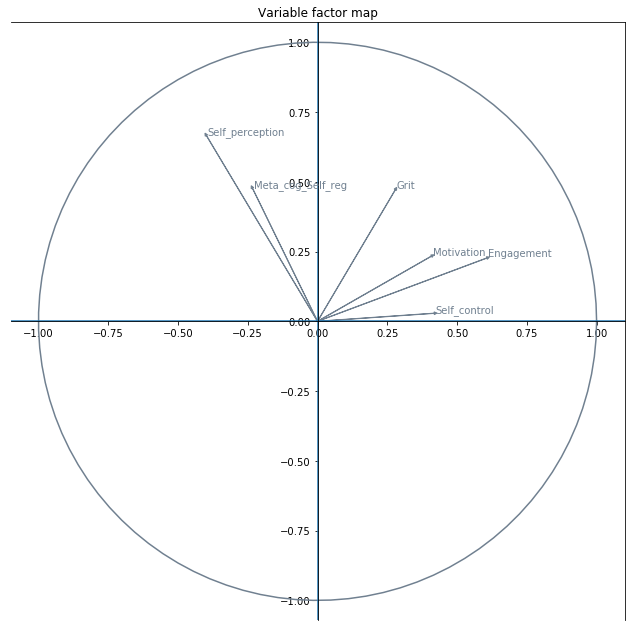

In [8]:
test2 = character_PCA(test1)

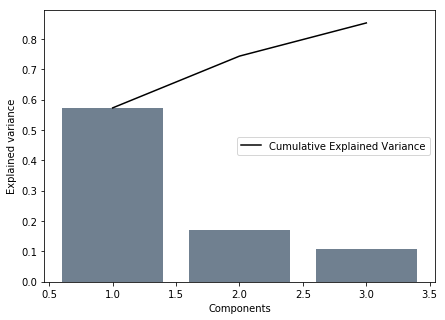

In [9]:
test2

In [10]:
test3 = character_kmeans(test1)

C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


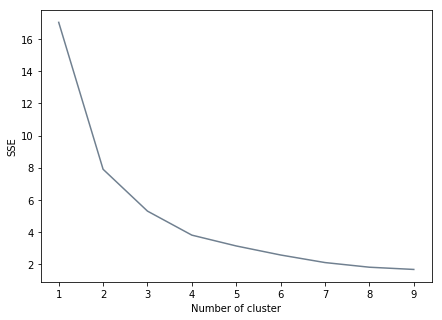

In [11]:
test3

In [12]:
test4, test5 = character_persona(test1, cluster_n = 4, 
                         cluster_coldict_n = {0:'cornflowerblue', 1:'mediumaquamarine', 2:'khaki', 3:'tomato'})

C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


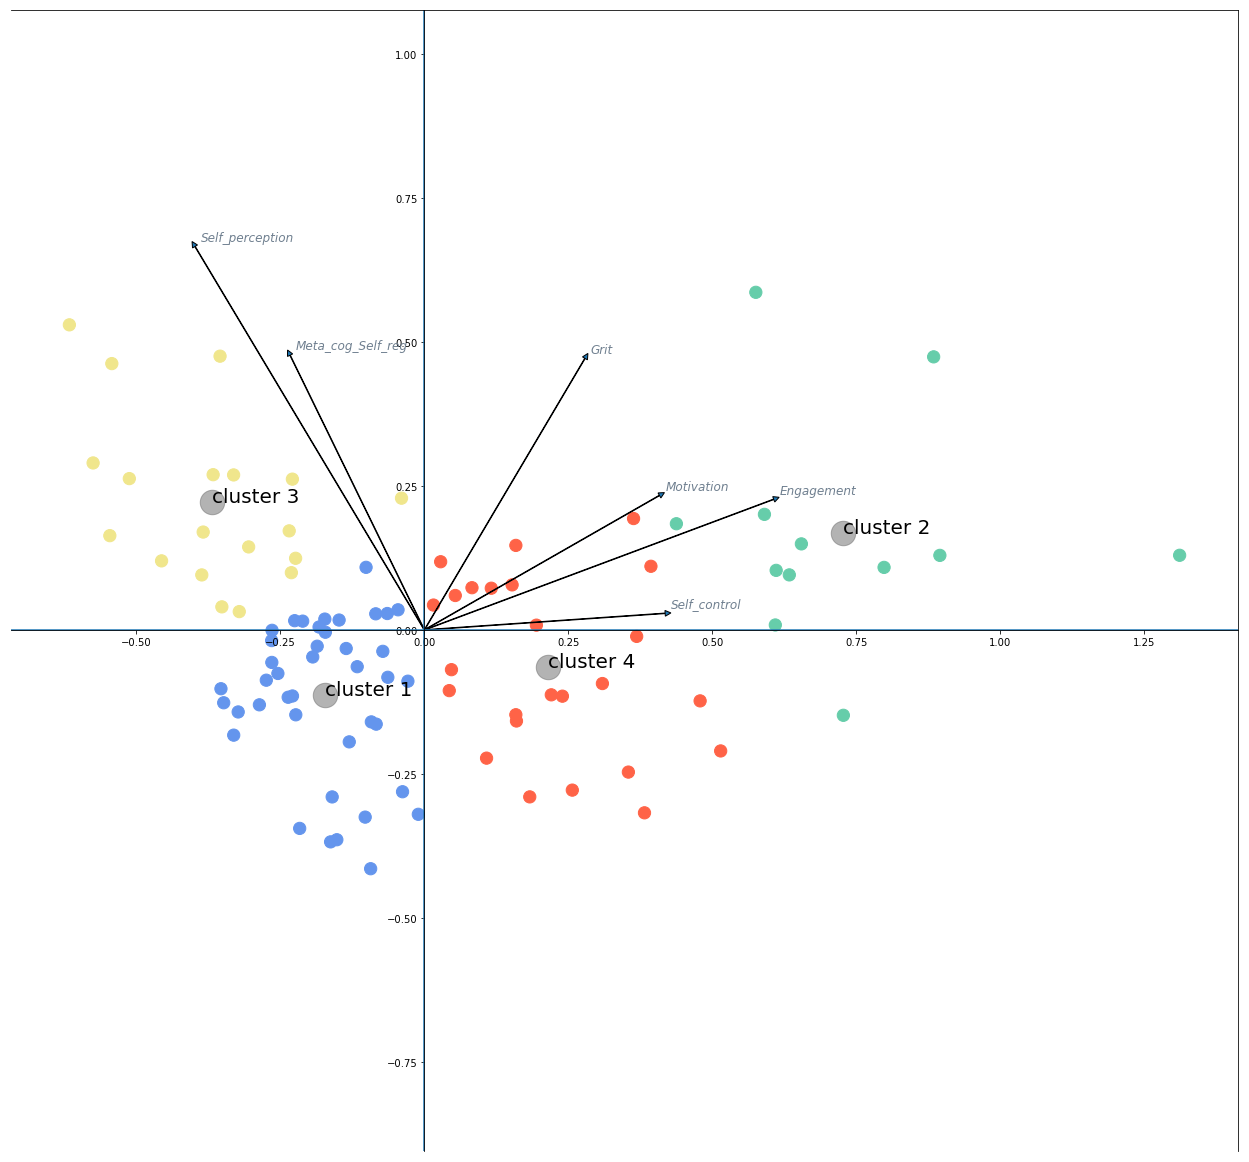

In [13]:
test4

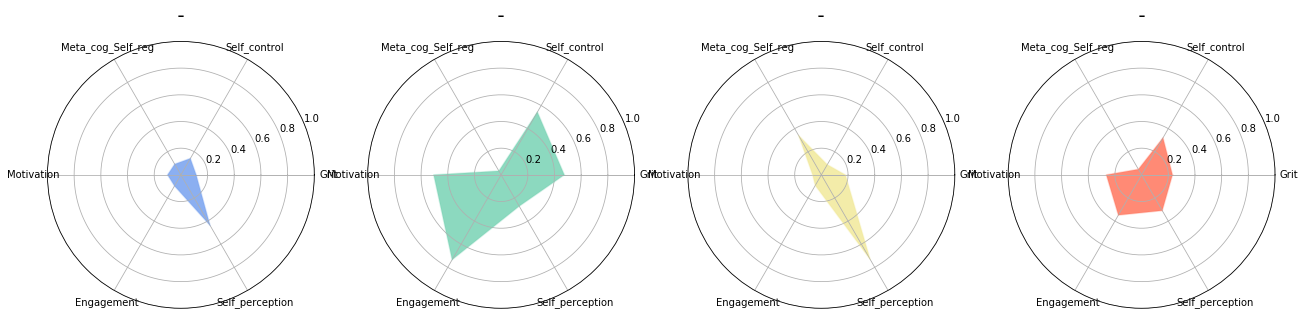

In [14]:
test5